<a href="https://colab.research.google.com/github/aabitokh/Assir-Bitokhov/blob/develop/%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F%20%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и модулей 

In [3]:
#первая предобученая модель
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gunzip cc.ru.300.bin.gz

--2020-12-25 08:48:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G  27.6MB/s    in 2m 38s  

2020-12-25 08:50:52 (27.1 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]



In [88]:
!pip3 install fasttext
!pip install pymorphy2
!pip3 install wget
!pip3 install gensim

In [6]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.manifold import TSNE

import re
import nltk
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN

import fasttext
import pymorphy2

import zipfile
import wget
import gensim

from gensim.models import Word2Vec

from nltk import word_tokenize

from nltk.probability import FreqDist

In [7]:
#инициализация предобученной модели
ft_model = fasttext.load_model('cc.ru.300.bin')

In [8]:
morph = pymorphy2.MorphAnalyzer()
bad_pos = {'CONJ', 'PREP', 'NPRO', 'PRCL'}

In [9]:
def clean_text(text):
    text = re.sub(r'[^\w\s]',' ', text)
    text = text.lower()
    clean_text = []
    for word in text.split():
        if not word:
            continue
        if morph.parse(word)[0].tag.POS in bad_pos:
            continue
        word = morph.parse(word)[0].normal_form
        if word not in stop_words:
          clean_text.append(word)
        else:
          continue
    return ' '.join(clean_text)

def get_sentence_vector(sentence):
    vec = np.zeros_like(ft_model.get_word_vector('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
        vec += ft_model.get_word_vector(word)
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

def get_token(series):
    tokens = []
    series.apply(lambda x: tokens.extend(word_tokenize(x)))

    text_clean = nltk.Text(tokens)
    fdist = FreqDist(text_clean)
    print(fdist.most_common(30))

    plt.figure(figsize=(20,10))
    fdist.plot(30,cumulative=False)

In [10]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("russian")
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
data_path = '2 маски - Разметка.csv'

In [12]:
data = pd.read_csv(data_path, header = None, names = ['comment', 'class'])

# Предобработа данных 

In [13]:
data.head()

,comment,class
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какой-нибудь пода...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой


In [14]:
data['text_clean'] = data['comment'].map(clean_text)

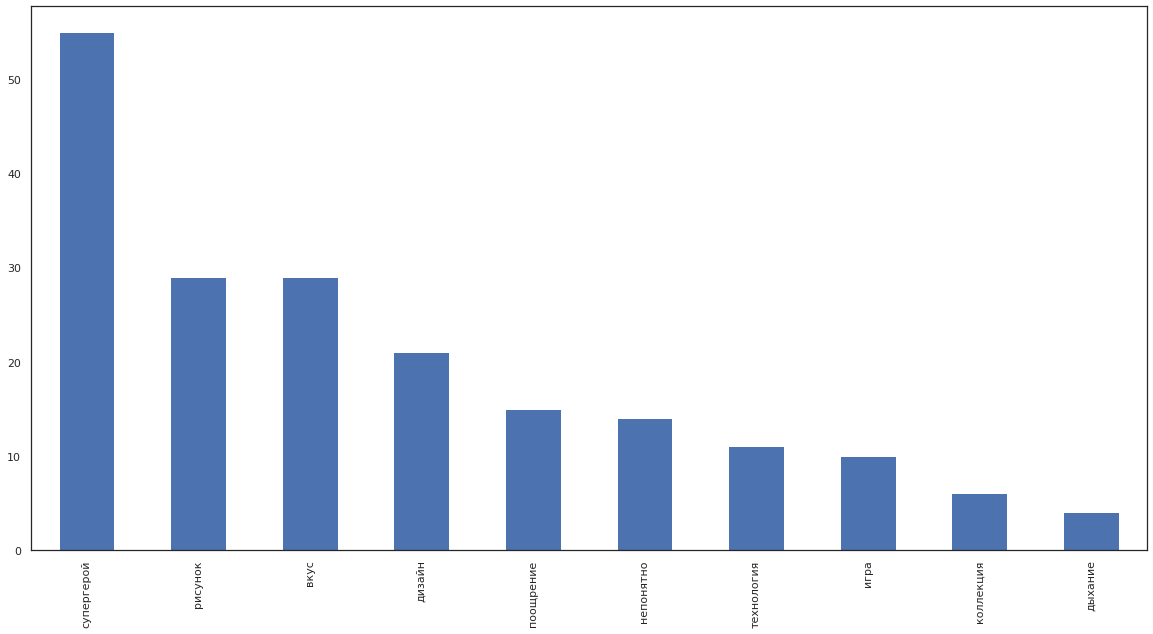

In [15]:
#оценка распределения классов 
plt.figure(figsize=(20,10))
data['class'].value_counts().plot.bar();

Чаще всего оставляют коменты про супергероев. примерно в одной размерности предлагают работать с темами вкус, рисунок и дизайн.

Скорее всего самые популярные классы станут самыми большими и плотными кластерами, которые проще всего будет определить. 

Интересно, что именно предлагают сделать со вкусом масок. Можно посмотреть на примеры. 

In [16]:
data[data['class']=='вкус'].sample(5)

,comment,class,text_clean
52,Вкусный запах,вкус,вкусный запах
187,чупачупс внутри!,вкус,чупачупс
177,встроенная соска,вкус,встроить соска
93,"к каждой маске выдавать ребенку аксессуар, игр...",вкус,каждый маска выдавать ребёнок аксессуар игрушк...
63,"Что-то съедобное на обратной стороне маски, мо...",вкус,съедобный обратный сторона маска мороженое кон...


То есть категория вкус больше про всякие запахи для масок. Хорошо хоть облизывать не предлагают. 

Вообще реплик довольно мало выходит, поэтому обучать какие-то модели на них - дохлое дело. Разреженные матрицы получаются неинформативными и кластеры не угадываются. Поэтому для извлечения из слов информации лучше взять предобученные модели для русского языка. Например, пойдет предложенная из фасттекста. 

# Частотный анализ 

[('маска', 181), ('сделать', 27), ('герой', 27), ('ребёнок', 26), ('который', 23), ('супергерой', 18), ('игра', 14), ('любимый', 13), ('мультик', 11), ('носить', 11), ('разный', 10), ('персонаж', 10), ('запах', 9), ('животное', 8), ('ношение', 8), ('нарисовать', 7), ('придумать', 7), ('весь', 7), ('набор', 6), ('мультфильм', 6), ('цвет', 6), ('рисунок', 6), ('менять', 6), ('нужно', 6), ('показать', 6), ('популярный', 5), ('детский', 5), ('мочь', 5), ('получать', 5), ('каждый', 5)]


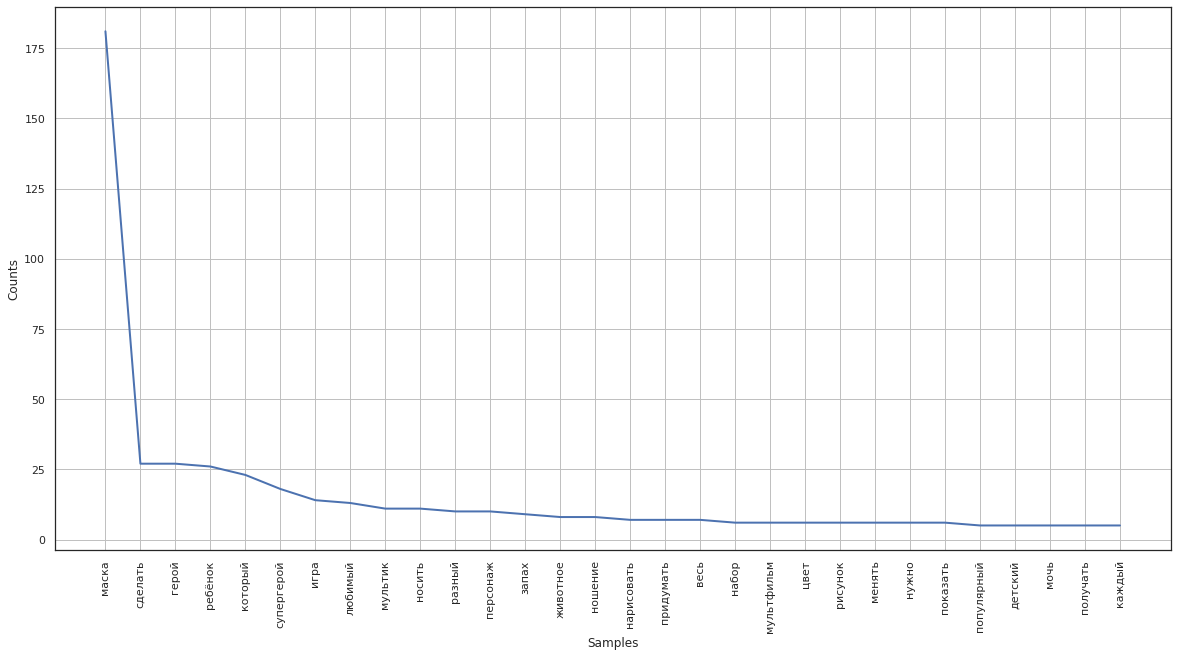

In [19]:
get_token(data['text_clean'])

Сильно выбивается слово маска, вполне возможно, что такой частый интент может служить шумом. 

Можно попробовать убрать из текста само слово маска и объединить похожие слова, типа "герой" и "супергерой". 

Так ручками можно посмотреть основные интенты и убрать те, которые не несут сильной смысловой нагрузки и встречаются у разных классов - так получится лучше разделить кластеры. 

In [20]:
#вот тут можно проверить интент
data[data['text_clean'].str.contains('время')]

,comment,class,text_clean
14,"маски с картинками изнутри, которые показывают...",дыхание,маска картинка изнутри который показываться по...
147,сделать маску которая бы меняла рисунок в зави...,рисунок,сделать маска который менять рисунок зависимос...
181,"маски, меняющие вид спустя сколько-то времени ...",технология,маска менять вид сколько время ношение


In [21]:
#простите за это
def best_text(text):
    text = re.sub(r'маска','', text)
    text = re.sub('[^а-яА-Я ]', '', text)
    text = re.sub('который', '', text)
    text = re.sub('супергерой', 'герой', text)
    text = re.sub('ребнок', '', text)
    text = re.sub('любимый', '', text)
    text = re.sub('разный', '', text)
    text = re.sub('ношение', '', text)
    text = re.sub('придумать', '', text)
    text = re.sub('весь', '', text)
    text = re.sub('набор', '', text)
    text = re.sub('цвет', 'рисунок', text)
    text = re.sub('нужно', '', text)
    text = re.sub('мочь', '', text)
    text = re.sub('каждый', '', text)
    text = re.sub('надеть', '', text)
    text = re.sub('носить', '', text)
    text = re.sub('показать', '', text)
    text = re.sub('популярный', '', text)
    text = re.sub('детский', '', text)
    text = re.sub('день', '', text)
    text = re.sub('нос', '', text)
    text = re.sub('сделать', '', text)
    text = re.sub('мультфильм', 'мультик', text)
    text = re.sub('нарисовать', 'рисовать', text)
    text = re.sub('задание', '', text)
    text = re.sub('эмоция', '', text)
    text = re.sub('мульт', 'мультик', text)
    text = re.sub('твой', '', text)
    text = re.sub('маленький', '', text)
    text = re.sub('тд', '', text)
    text = re.sub('время', '', text)





    return text 
    

In [22]:
data['text_clean'] = data['text_clean'].apply(lambda x: best_text(x))

[('герой', 45), ('мультикик', 17), ('игра', 14), ('рисунок', 12), ('рисовать', 11), ('персонаж', 10), ('запах', 9), ('животное', 8), ('менять', 6), ('получать', 5), ('вкус', 5), ('соска', 5), ('съедобный', 4), ('друг', 4), ('играть', 4), ('настроение', 4), ('балл', 4), ('мультик', 4), ('часть', 4), ('конфета', 4), ('лицо', 4), ('встроить', 4), ('вид', 4), ('принтами', 3), ('конфетка', 3), ('должный', 3), ('коллекция', 3), ('изнутри', 3), ('леденец', 3), ('надевать', 3)]


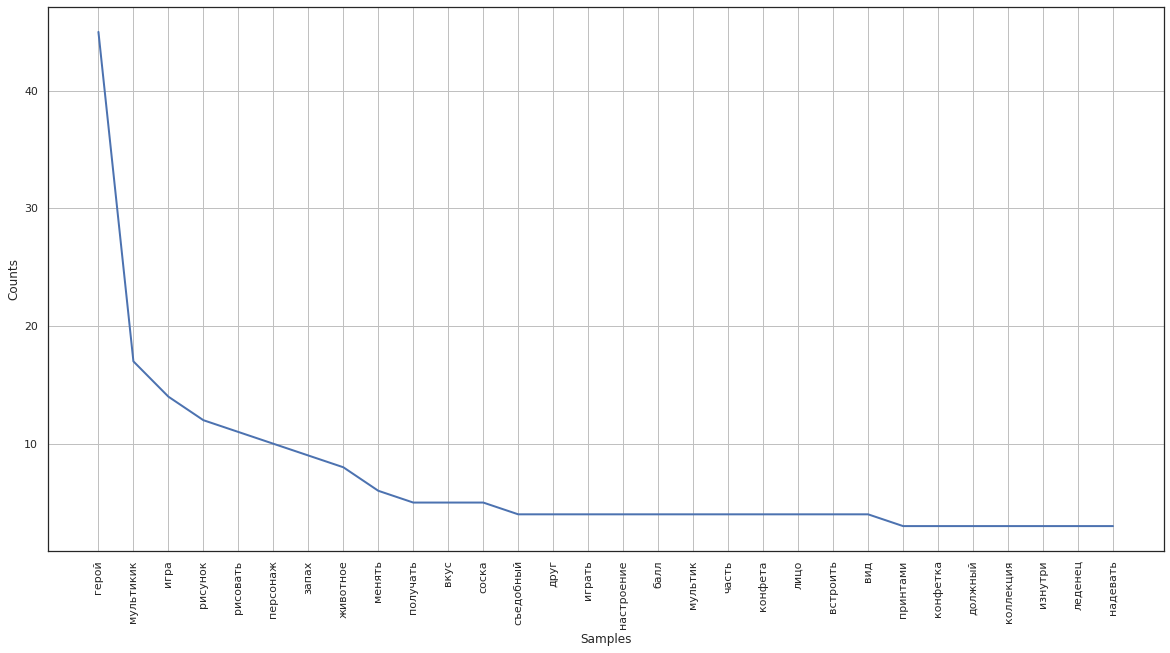

In [24]:
get_token(data['text_clean'])

# Кластеризация

Сначала можно взглянуть на расстояние между элементами

In [25]:
data['vector'] = data['text_clean'].map(get_sentence_vector)

In [26]:
#перебор параметров для knn 
knn_params = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier(weights='distance')
knn_grid = GridSearchCV(knn, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [34]:
#вертикальное объединение массивов в 1 большой массив 
vectors = np.vstack(data['vector'].values) 
knn_grid.fit(vectors, np.zeros(len(data)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=True)

In [35]:
knn_grid.best_params_

{'n_neighbors': 1}

In [40]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=1)
knn.fit(vectors, np.zeros(len(data)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [39]:
query_index = 0
query_label = data['class'].iloc[query_index]

In [41]:
#возвращает дистанцию до n ближайших соседей и индексы точек
distances, indexes = knn.kneighbors(vectors[[query_index]], n_neighbors=len(data))

In [42]:
#сколько раз встречается тестовый класс "супергерой"
support = (data['class'] == query_label).sum()

In [43]:
#55 ближайших соседей 
top_predictions = data['class'].iloc[indexes[0][:support]]

In [44]:
print('Accuracy по в классу для этого предложения:', (top_predictions == query_label).mean())


Accuracy по в классу для этого предложения: 0.8363636363636363


In [313]:
# на размеченных данных получилось около 10 классов, в идеале и кластеров должно быть примерно столько же 
data['class'].nunique()

10

In [46]:
print('Расстояние\tНормализированный текст')
for i, d  in zip(indexes[0], distances[0]):
    print(round(d, 2), data['class'].iloc[i], data['text_clean'].iloc[i], sep='\t')

Расстояние	Нормализированный текст
0.0	супергерой	  изображение  герой массовый культура
0.67	супергерой	 герой  рисунок 
0.67	супергерой	 изображение  герой смешарик
0.67	супергерой	известный герой
0.67	супергерой	 герой
0.67	супергерой	  герой  
0.67	супергерой	  герой
0.67	супергерой	    герой
0.67	супергерой	 герой
0.67	супергерой	 герой
0.68	супергерой	герой мультикик герой начать  
0.68	супергерой	 должный составлять коллекция изображать герой современный мультикик
0.68	супергерой	  принтами животное герой  герой мультикик
0.7	супергерой	 животное  герой
0.7	супергерой	 рисовать известный  герой
0.7	супергерой	родитель  парный  герой персонаж мультикик
0.71	супергерой	  часть костюм герой
0.71	супергерой	 часть костюм герой
0.71	супергерой	создать уникальный    герой
0.71	супергерой	мультикик главный герой начать  
0.72	супергерой	паттерн   герой
0.73	супергерой	 рисовать  герой
0.75	супергерой	рисовать герой мультикик
0.75	супергерой	 мультикик добавить герой  сделпть модный
0.7

In [52]:
result ={}
for eps in np.arange(0.1, 1, 0.005):
    clustering = DBSCAN(eps=eps, min_samples=3).fit(vectors)
    result[eps]= len(set(clustering.labels_))

In [53]:
max(result.values())

6

In [55]:
#расстояние для лучшего срабатывания DBSCAN
[dist for dist, n in result.items() if n == max(result.values())]

[0.6000000000000004,
 0.6050000000000004,
 0.6100000000000004,
 0.6150000000000004,
 0.6200000000000004,
 0.6250000000000004,
 0.6300000000000004,
 0.6350000000000005,
 0.6400000000000005,
 0.6450000000000005,
 0.6500000000000005,
 0.6550000000000005,
 0.6600000000000005,
 0.6700000000000005,
 0.6750000000000005,
 0.6800000000000005,
 0.6850000000000005,
 0.6900000000000005,
 0.6950000000000005,
 0.7150000000000005,
 0.7200000000000005,
 0.7250000000000005,
 0.7300000000000005,
 0.7450000000000006,
 0.7500000000000006,
 0.7550000000000006,
 0.7600000000000006,
 0.7650000000000006,
 0.7700000000000006,
 0.7750000000000006,
 0.7800000000000006,
 0.7850000000000006,
 0.7900000000000006]

In [56]:
clustering = DBSCAN(eps=0.6250000000000004, min_samples=3).fit(vectors)

In [57]:
clustering.labels_

array([-1, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1,  1, -1,  0, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  0,  0,
       -1,  1,  0,  0, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0, -1,  0, -1,  0, -1, -1, -1, -1,  2, -1,  3,  0, -1,
        0, -1, -1,  3, -1, -1, -1, -1,  1, -1, -1,  2, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1,  3, -1, -1, -1,
       -1, -1,  4, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0, -1, -1,  0,
       -1, -1, -1,  3,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,  1, -1,  2,
        0, -1, -1,  1, -1, -1,  1,  2,  1,  0, -1,  4, -1,  0, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1])

In [58]:
data['pred'] = clustering.labels_

In [59]:
v_measure_score(data['class'], data['pred'])

0.27390291874763256

V-мера получилась не слишком большой с помощью DBSCAN, эту модель можем взять за базлайн и попробовать посмотреть, какие алгоритмы лучше смогут считать кластеры тут. 

## Визуализация

Полезным бывает сначала взглянуть на клестеры, для этого лучше попробовать алгоритмы снижения размерности. 

PCA не очень справлялся, поэтому я его выкинул, оставил только TSNE. 

In [60]:
tsne = TSNE()
xy = tsne.fit_transform(vectors)

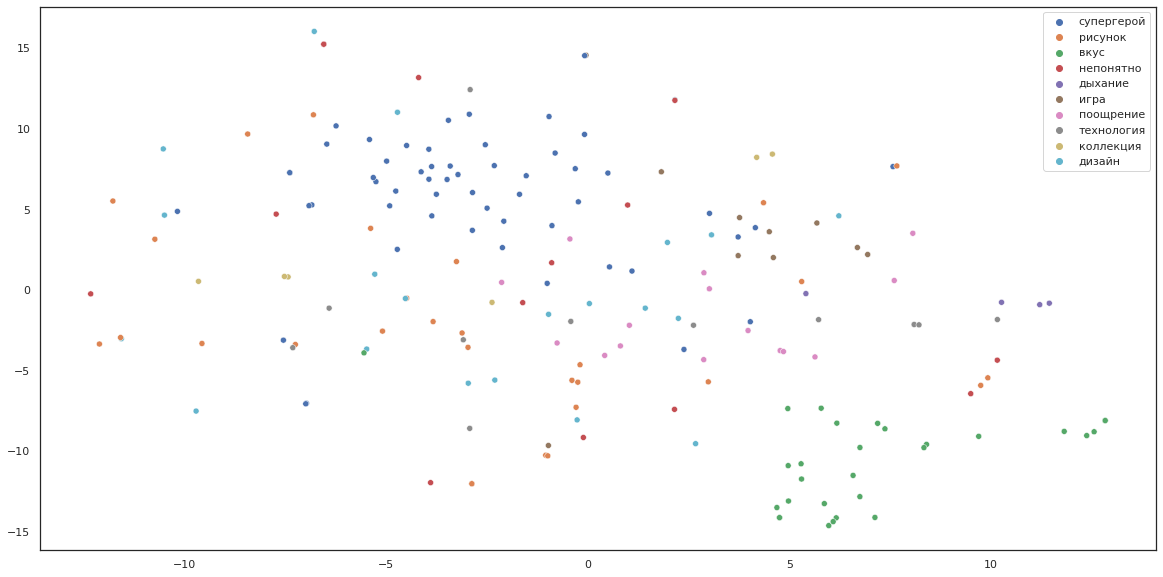

In [61]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['class'].values)

Если смотреть по данным ручной разетки, то хорошо выделяются классы "вкус" и "супергерой". "Рисунок" немного растекся. 

In [62]:
y = data['class']

кластеров - 1, метрика - 1.7541242171112808e-16
кластеров - 2, метрика - 0.31981809947635426
кластеров - 3, метрика - 0.36885685866708007
кластеров - 4, метрика - 0.34323669550341007
кластеров - 5, метрика - 0.4097490648032907
кластеров - 6, метрика - 0.4283945621177208
кластеров - 7, метрика - 0.4313461186136358
кластеров - 8, метрика - 0.3595163247892389
кластеров - 9, метрика - 0.36120602479843705
кластеров - 10, метрика - 0.36878524279749475
кластеров - 11, метрика - 0.44041608250692055


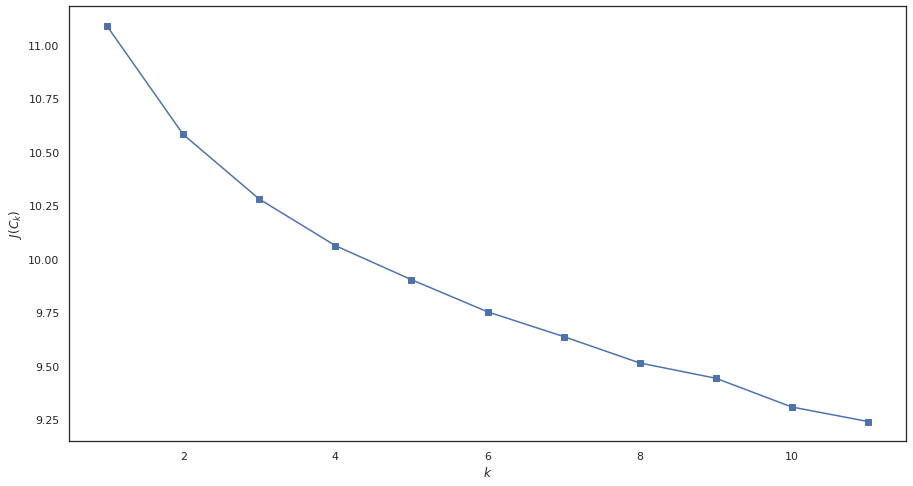

In [65]:
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(vectors)
    inertia.append(np.sqrt(kmeans.inertia_))
    result = v_measure_score(y, kmeans.predict(vectors))
    print(f'кластеров - {k}, метрика - {result}')

plt.figure(figsize = (15,8))
plt.plot(range(1, 12), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

K-means довольно надежный алгоритмы, хоть и простой, с такими кластерами отрабатывает лучше чем DBSCAN, особенно неплохо он находит 11 кластеров или 7. 

А вот если смотреть на алгоритм k-means, то результат сильно лучше получается, особенно при 11 кластерах. 

In [74]:
kmeans_7 = KMeans(n_clusters=7, random_state=42).fit(vectors)
kmeans_11 = KMeans(n_clusters=11, random_state=42).fit(vectors)

In [75]:
data['pred_kmeans_7'] = kmeans_7.labels_
data['pred_kmeans_11'] = kmeans_11.labels_

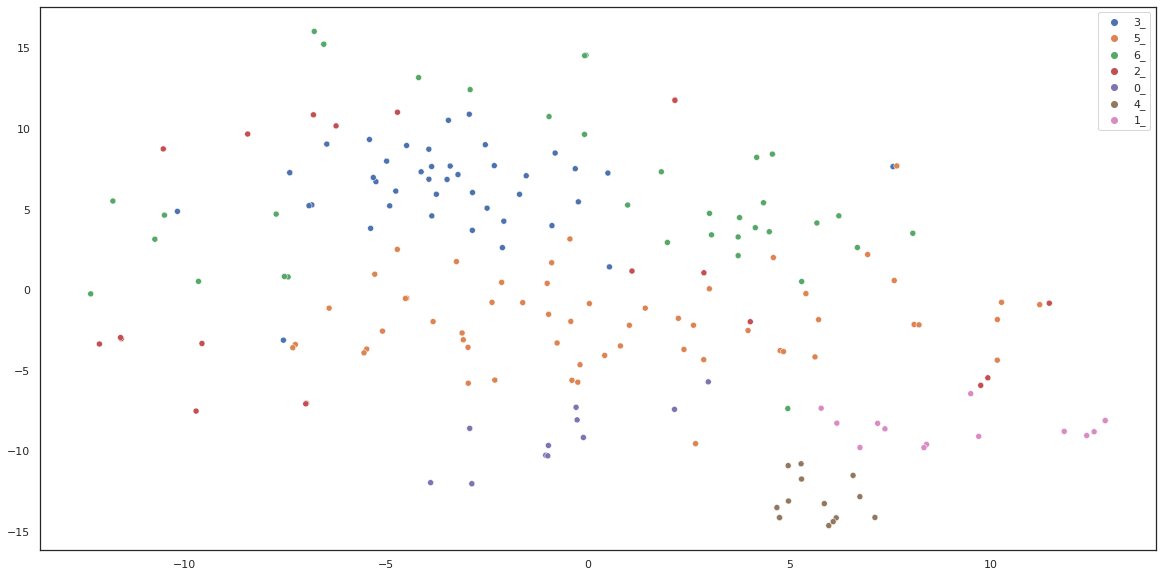

In [76]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred_kmeans_7'].map(lambda x: str(x) + '_').values)

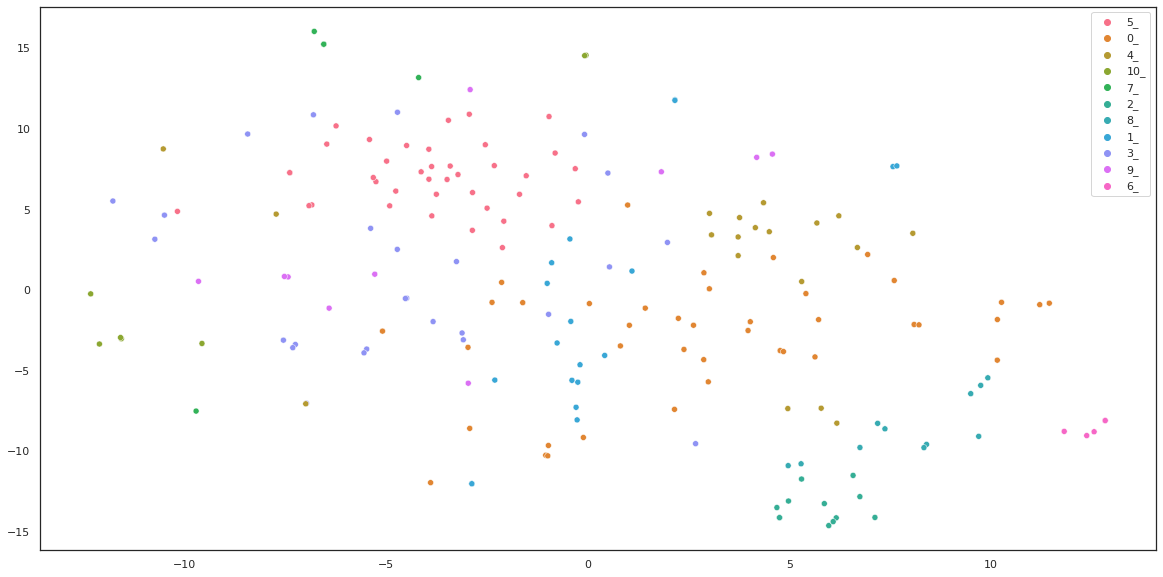

In [77]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred_kmeans_11'].map(lambda x: str(x) + '_').values)

На K-means действительно получается лучше кластеризовать этот текст. 
На рисунке кластеры стали отслеживаться гораздо лучше. Мне кажется, что 7 кластеров визуально различается лучше, чем 11. 

In [84]:
#проверка на адекватность 
agglo1 = AgglomerativeClustering(n_clusters = 11, affinity='euclidean')
agglo1.fit(vectors)
v_measure_score(y, agglo1.labels_)

# Проба другой предобученной модели


In [89]:
#вторая модель word_2_vec
model_url = 'http://vectors.nlpl.eu/repository/20/65.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [90]:
def get_sentence_vector_second(sentence):
    vec = np.zeros_like(model.word_vec('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
      try:
        vec += model.word_vec(word)
      except:
        continue
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

In [91]:
data['vector_second'] = data['text_clean'].map(get_sentence_vector_second)

In [92]:
second_vectors =  np.vstack(data['vector_second'].values) 

кластеров - 1, метрика - 1.7541242171112808e-16
кластеров - 2, метрика - 0.28545159928952674
кластеров - 3, метрика - 0.36058070789013247
кластеров - 4, метрика - 0.3727565514571705
кластеров - 5, метрика - 0.3883149231966258
кластеров - 6, метрика - 0.3841357980669633
кластеров - 7, метрика - 0.3725043536893656
кластеров - 8, метрика - 0.4268533809720606
кластеров - 9, метрика - 0.4240241893988367
кластеров - 10, метрика - 0.4084174649096959
кластеров - 11, метрика - 0.4362807827530655


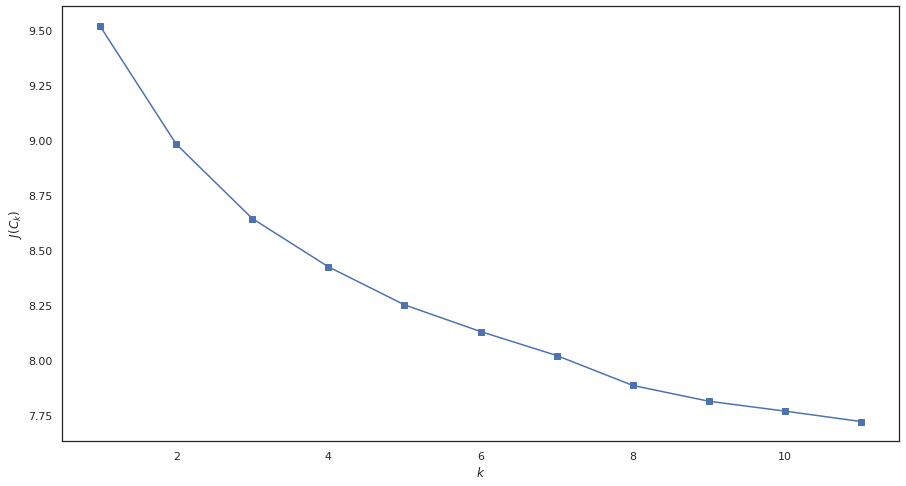

In [94]:
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(second_vectors)
    inertia.append(np.sqrt(kmeans.inertia_))
    result = v_measure_score(y, kmeans.predict(second_vectors))
    print(f'кластеров - {k}, метрика - {result}')

plt.figure(figsize = (15,8))
plt.plot(range(1, 12), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

На этой модели лучше всего показали себя 11 клстеров и 8. 

In [101]:
kmeans_8_s = KMeans(n_clusters=8, random_state=42).fit(vectors)
kmeans_11_s = KMeans(n_clusters=11, random_state=42).fit(vectors)

data['pred_kmeans_s_8'] = kmeans_8_s.labels_
data['pred_kmeans_s_11'] = kmeans_11_s.labels_

In [105]:
tsne = TSNE(random_state=42)
xy = tsne.fit_transform(second_vectors)

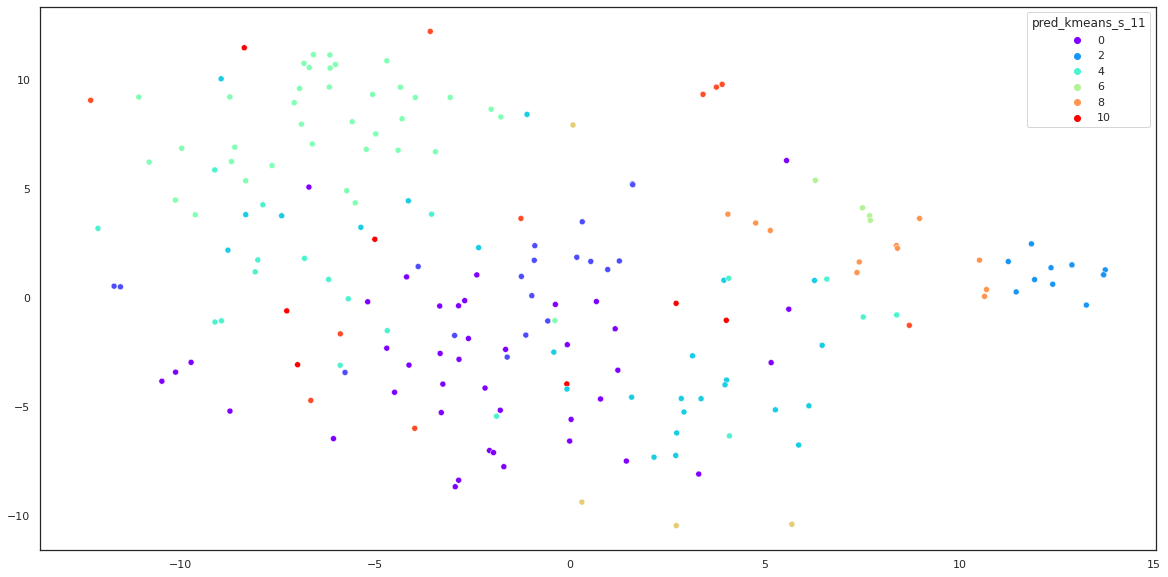

In [106]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred_kmeans_s_11'], palette = 'rainbow')

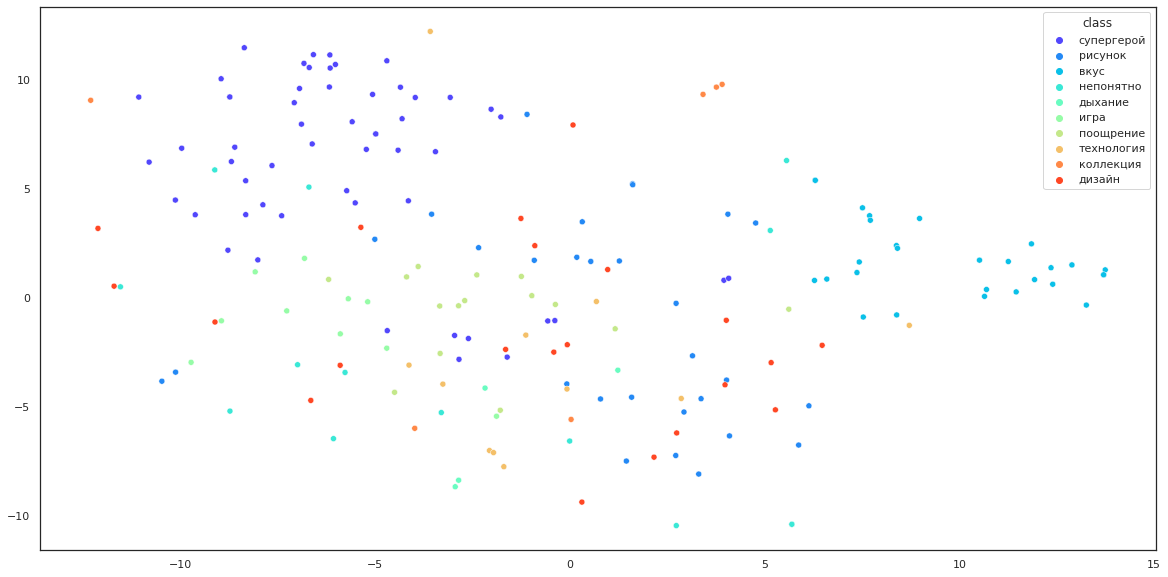

In [107]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['class'], palette = 'rainbow')

# Выводы

Клстеризовать такие тексты действительно можно, но данных должно быть значительно больше, чем 200 записей, тогда и метрика должна подтягуться. 

Стандартные подходы вроде мешка слов не дали нужного результата, потому информацию лучше брать из предобченных моделей (их тут использовал парочку).


На реальном датасете можно составить свой специфический, расширенный стопвордс-лист, так как тематика все равно прослеживается и отличается от общей по языку. 

Было много мусорных слов, которые встречались в разных классах, тем самым сближая кластеры между собой - эти слова не несут смысловой нагрузки и не помогают выделить кластеры, поэтому он них лучше избавляться. 

Пример: "маска", "сделать", "твой", "свой", "популярный". 

Если данных будет больше, то можно покопаться и составить большой словарь синонимов, это тоже должно помочь лучше кластеризовать тексты. 

Что еще можно сделать: попробовать прогнать этот алгоритм на би- и триграммах, может быть результат подрастет. 

 **Результаты по V-мере около 0.42-0.44.**
